##Lab 2 - Linear regression

##The assignment

The context is “Predicting vibrational frequencies from the external chemical environment”. That is given a number descriptors, 
what can we infer about the frequency. Or in reverse, what information regarding the structure is hidden in the frequency.  You 
can use the proposed work-ﬂow below, or explore the data more freely. However, you should demonstrate the use of the 
techniques we have covered in the lecture/workshops. 

##Proposed  work-ﬂow: 

Load the csv-ﬁles with with frequencies and descriptors into a pandas data-frame.

NOTE: There is a reference bulk data-set for comparison alongside the surface data described above.

Perform a few ANOVA tests for all/selected descriptors in the surface and bulk data-set to get a feel for what correlation there are among the various descriptors.

Perform PCA or LDA analysis on the data. E.g. to compare if bulk and surface data can be discriminated.

Perform a number regressions and try to ﬁnd a model with a reduced number of independent variables that can make robust prediction of frequencies.

Make a correlation plot similar to that of Libowitzky (slide 8), but with surface and bulk data highlighted. Draw a ﬁtted model curve from e.g. i kernel ridge regression on top of the data.  

Summarise your ﬁndings into a reasonably comprehensive jupyter notebook. Write down some reﬂections and interesting ﬁndings from your “research”.


ANOVA:

Look if the variance between the descriptors are correlated or not 
Compare exp surface data with bulk data to see if there is a difference between the data sets. 

In [98]:
#Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as iter
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools as iter
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats

Masking in pandas df: 

first condition:
data_cured_step1 = data[data['Freq'] < 4000]
Second condition:
data_cured_step2 = data[data_cured_step1['rOO'] < 4.0]

eller & nästa argument

In [99]:
#Import data

#Experimental data
data = pd.read_csv('Suface_data.csv', sep=',')
data_df = pd.DataFrame(data)
#print(data_df)

#Bulk data for reference
bulk_data_1 = pd.read_csv('bulk_data_1.csv', sep=',')
bulk_data_2 = pd.read_csv('bulk_data_2.csv', sep=',')
#print(bulk_data_1, bulk_data_2)

#curing/removing unwanted parts of the data. Never had to do this for 
#surface_data or bulk_data_1. If bulk_data_2 is to be used, all entries without frequency data should be removed. 
#data_df_cured_step1 = data_df[data_df['acceptor_type']!='NaN']         #!= not equal to 
#print(data_df_cured_step1)


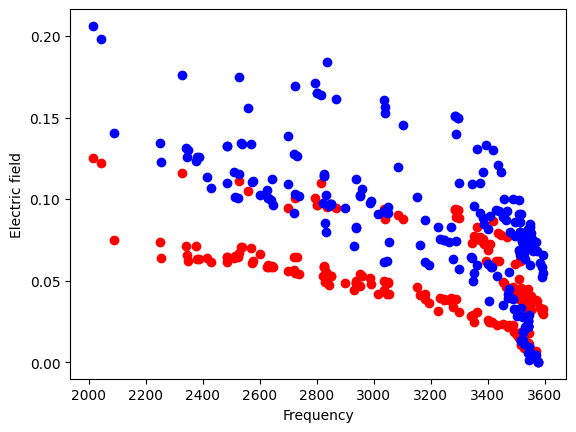

In [100]:
#Initial plotting of the data 
plt.xlabel("Frequency")
plt.ylabel("Electric field")
plt.scatter(data_df['Frequency'], data_df['EFddec'], color='red')
plt.scatter(data_df['Frequency'], data_df['EFfc'], color='blue')

In [101]:
#Do a statistical pairwise t-test on the two methods as independent values to calculate the electrical filed. 
#Null hypothesis is that they are the same. 
#By rejecting the null hypothesis, we show that the distributions are significally different. 

data_1 = data_df['EFddec']
data_2 = data_df['EFfc']

print("Mean value data_1: ",np.array(data_1).mean())
print("Mean value data_2: ",np.array(data_2).mean())
print("")
print("============================================================================================================")

# Perform the two independent samples t-test
t_test, p_value = stats.ttest_ind(data_1, data_2)

# Set significance level (α)
alpha = 0.05

# Compare the p-value with the significance level
if p_value < alpha:
    print("t-test:", t_test, "--> p-value: ",p_value," < ",alpha)
    print("Reject the null hypothesis. The distributions are significantly different.")
else:
    print("t-test:", t_test, "--> p-value: ",p_value," > ",alpha)
    print("Fail to reject the null hypothesis.")

Mean value data_1:  0.049493325706268854
Mean value data_2:  0.08632454280608085

t-test: -11.11659656543604 --> p-value:  2.0246798930113616e-25  <  0.05
Reject the null hypothesis. The distributions are significantly different.


In [102]:
##Do a statistical pairwise t-test on the two methods as dependent values to calculate the electrical filed. 
#Null hypothesis is that they are the same. 

data_1 = data_df['EFddec']
data_2 = data_df['EFfc']

print("Mean value data_1: ",np.array(data_1).mean())
print("Mean value data_2: ",np.array(data_2).mean())
print("")
print("============================================================================================================")

# Perform relative two-samples t-test
t_test, p_value = stats.ttest_rel(data_1, data_2)

# Set significance level (α)
alpha = 0.05

# Compare the p-value with the significance level
if p_value < alpha:
    print("t-test:", t_test, "--> p-value: ",p_value," < ",alpha)
    print("Reject the null hypothesis. The distributions are significantly different.")
else:
    print("t-test:", t_test, "--> p-value: ",p_value," > ",alpha)
    print("Fail to reject the null hypothesis.")



Mean value data_1:  0.049493325706268854
Mean value data_2:  0.08632454280608085

t-test: -28.932813655794973 --> p-value:  3.002530573764127e-76  <  0.05
Reject the null hypothesis. The distributions are significantly different.


Both the t-test for the independent matching and the pair-wise test gives that the distributions are significantly different. 

No lets do a full ANOVA of the data set:

In [103]:
#one way ANOVA for all descriptors in the data to se if they correlate
#The null hypotesis is that they are the same. 

surface_freq = data_df['Frequency']
surface_EFddec = data_df['EFddec']
surface_EFfc = data_df['EFfc']
surface_rHO = data_df['rHO']
surface_rOO = data_df['rOO']
surface_tOHO = data_df['tOHO']
surface_sOHQM = data_df['sOHQM']

F_test, p_value =stats.f_oneway(surface_freq, surface_EFddec, surface_EFfc, surface_rHO, surface_rOO, surface_tOHO, surface_sOHQM)

print("t-test: ",F_test," -> P-value: ",p_value)

t-test:  12835.0326625855  -> P-value:  0.0


p=0, we reject the null hypothesis that the distributions are the same. There is not a correlation between ALL of the descriptors. 
The anova test does not give much information. 

Now lets move on to try to compare the surface data to the bulk data given. 

In [104]:
#Parameters that exist in surface and bulk data, do pairwise t-test on all five descriptors. 
#EFfc, rHO, rOO, tOHO, sOH

#Prepare the data for the t-tests

surface_EFfc = data_df['EFfc']
surface_rHO = data_df['rHO']
surface_rOO = data_df['rOO']
surface_tOHO = data_df['tOHO']
surface_sOHQM = data_df['sOHQM']
bulk_EFfc = bulk_data_1['EFfc']
bulk_rHO = bulk_data_1['rHO']
bulk_rOO = bulk_data_1['rOO']
bulk_tOHO = bulk_data_1['tOHO']
bulk_sOH = bulk_data_1['sOH']

# Set significance level (α)
alpha = 0.05


# Perform the two independent samples t-test on EFfc
t_test, p_value = stats.ttest_ind(surface_EFfc, bulk_EFfc)

# Compare t-test for EFfc
print('The t-test for independent values for bulk and surface data for EFfc gives:')
if p_value < alpha:
    print("t-test:", t_test, "--> p-value: ",p_value," < ",alpha)
    print("Reject the null hypothesis. The distributions for EFfc are significantly different.")
else:
    print("t-test:", t_test, "--> p-value: ",p_value," > ",alpha)
    print("Fail to reject the null hypothesis, the distributions are not significantally different.")

print('==============================================================================================')

# Compare t-test for rHO

t_test, p_value = stats.ttest_ind(surface_rHO, bulk_rHO)

print('The t-test for independent values for bulk and surface data for rHO gives:')
if p_value < alpha:
    print("t-test:", t_test, "--> p-value: ",p_value," < ",alpha)
    print("Reject the null hypothesis. The distributions for rHO are significantly different.")
else:
    print("t-test:", t_test, "--> p-value: ",p_value," > ",alpha)
    print("Fail to reject the null hypothesis, the distributions are not significantally different.")

print('==============================================================================================')

# Compare t-test for rOO

t_test, p_value = stats.ttest_ind(surface_rOO, bulk_rOO)

print('The t-test for independent values for bulk and surface data for rOO gives:')
if p_value < alpha:
    print("t-test:", t_test, "--> p-value: ",p_value," < ",alpha)
    print("Reject the null hypothesis. The distributions for rOO are significantly different.")
else:
    print("t-test:", t_test, "--> p-value: ",p_value," > ",alpha)
    print("Fail to reject the null hypothesis, the distributions are not significantally different.")

print('==============================================================================================')

# Compare t-test for tOHO

t_test, p_value = stats.ttest_ind(surface_tOHO, bulk_tOHO)

print('The t-test for independent values for bulk and surface data for tOHO gives:')
if p_value < alpha:
    print("t-test:", t_test, "--> p-value: ",p_value," < ",alpha)
    print("Reject the null hypothesis. The distributions for tOHO are significantly different.")
else:
    print("t-test:", t_test, "--> p-value: ",p_value," > ",alpha)
    print("Fail to reject the null hypothesis, the distributions are not significantally different.")

print('==============================================================================================')

# Compare the values for sOHQM (surface) vs sOH (bulk)

t_test, p_value = stats.ttest_ind(surface_sOHQM, bulk_sOH)

print('The t-test for independent values for bulk and surface data for sOHQM (surface) vs sOH (bulk) gives:')
if p_value < alpha:
    print("t-test:", t_test, "--> p-value: ",p_value," < ",alpha)
    print("Reject the null hypothesis. The distributions for sOHQM (surface) vs sOH (bulk) are significantly different.")
else:
    print("t-test:", t_test, "--> p-value: ",p_value," > ",alpha)
    print("Fail to reject the null hypothesis, the distributions are not significantally different.")

The t-test for independent values for bulk and surface data for EFfc gives:
t-test: 0.07946553908202494 --> p-value:  0.9367127995627849  >  0.05
Fail to reject the null hypothesis, the distributions are not significantally different.
The t-test for independent values for bulk and surface data for rHO gives:
t-test: 9.565116784009165 --> p-value:  3.3883816064842213e-19  <  0.05
Reject the null hypothesis. The distributions for rHO are significantly different.
The t-test for independent values for bulk and surface data for rOO gives:
t-test: 7.402413455236348 --> p-value:  1.2286090163507606e-12  <  0.05
Reject the null hypothesis. The distributions for rOO are significantly different.
The t-test for independent values for bulk and surface data for tOHO gives:
t-test: -14.301144125320679 --> p-value:  4.255811034960807e-36  <  0.05
Reject the null hypothesis. The distributions for tOHO are significantly different.
The t-test for independent values for bulk and surface data for sOHQM (s

From the pair wise t-test on surface and bulk data, the electrical field force calculation is seen to not be significantly different for surface and bulk data. The way of calculation this descriptor in the two different computational models gives similar behaviour/electric field in both bul and surface. 

For the bond lengths, rHO, rOO, tOHO, there is significant difference between the distributions calculated for the surface vs for the bulk system. This feels reasonable as the structure of the surface should differ from the bulk, resulting in different bond lengths (at least on average). 

For sOHQM (surface) vs SOH (bulk), there is also a significant difference. This says something about the diffrenet models... 

Next task will be to do a LCA analysis. For this I will create a dataframe with some descriptors from the surface data and with some from the bulk. 

In [130]:
#Prepare the dataframe with data from both surface and 
LDA_df = data
LDA_df['bulk_EFfc'] = bulk_data_1['EFfc']
LDA_df['bulk_rHO'] = bulk_data_1['rHO']
LDA_df['bulk_rOO'] = bulk_data_1['rOO']
LDA_df['bulk_tOHO'] = bulk_data_1['tOHO']
LDA_df['bulk_sOH'] = bulk_data_1['sOH']

print(LDA_df)

LDA_df = LDA_df[LDA_df.acceptor_type.notnull()]

print(LDA_df)

##Problem with the shape of the array for the LCA calculations look more at this later. 

#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Perform Linear Discriminant Analysis
#lda = LinearDiscriminantAnalysis(n_components=16)
#X_lda = lda.fit_transform(LDA_df, )

#Plot the results
#target_names = [('Frequency', 'acceptor_type', 'Type', 'EFddec', 'EFfc', 'rHO', 'rOO', 'tOHO', 'sOH', 'sOHQM', 'bulk_EFfc', 'bulk_rHO', 'bulk_rOO', 'bulk_tOHO', 'bulk_sOH')]
#colors = ['navy', 'turquoise']
#plt.figure()
#for color, i, target_name in zip(colors, [0, 1], target_names):
#    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], color=color, alpha=0.8, lw=2, label=target_name)
#plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.title('LDA')
#plt.xlabel('LDA Component 1')
#plt.ylabel('LDA Component 2')
#plt.show()


     Unnamed: 0  Frequency acceptor_type       Type    EFddec      EFfc  \
0             0   3577.868           NaN      water  0.000151  0.000402   
1             1   3577.868           NaN      water  0.000152  0.000405   
2             2   3511.409           H2O      water  0.015010  0.032563   
3             3   2952.498           O2-      water  0.053806  0.102202   
4             4   3514.452           OH-  hydroxide  0.039665  0.066010   
..          ...        ...           ...        ...       ...       ...   
212         212   2816.551           OH-  hydroxide  0.109617  0.163932   
213         213   2528.199           OH-  hydroxide  0.110814  0.174560   
214         214   3584.097           NaN  hydroxide  0.032979  0.060920   
215         215   3047.550           OH-      water  0.041758  0.062331   
216         216   2527.841           OH-      water  0.066925  0.115264   

          rHO       rOO        tOHO       sOH   sOHQM  bulk_EFfc  bulk_rHO  \
0    3.000000  3.5000

Perform a number regressions and try to ﬁnd a model with a reduced number of independent variables that can make 
robust prediction of frequencies.

Make a correlation plot similar to that of Libowitzky (slide 8), but with surface and bulk data highlighted. Draw a ﬁtted 
model curve from e.g. i kernel ridge regression on top of the data.  

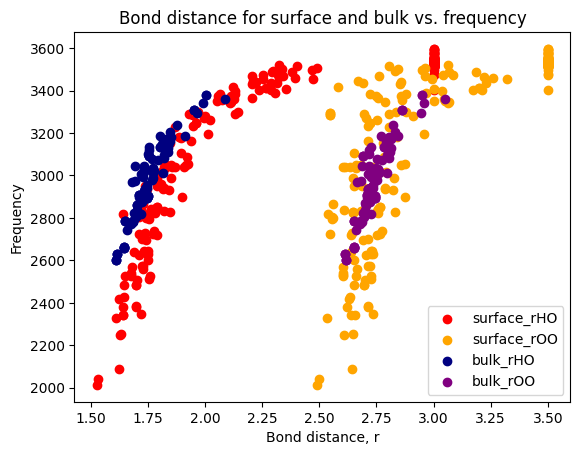

In [126]:
bonds = []
bonds_df = pd.DataFrame(bonds)

bonds_df['surface_freq']=data_df['Frequency']
bonds_df['surface_rHO'] = data_df['rHO']
bonds_df['surface_rOO'] = data_df['rOO']
bonds_df['surface_tOHO'] = data_df['tOHO']
bonds_df['bulk_freq']= bulk_data_1['Frequency']
bonds_df['bulk_rHO'] = bulk_data_1['rHO']
bonds_df['bulk_rOO'] = bulk_data_1['rOO']
bonds_df['bulk_tOHO'] = bulk_data_1['tOHO']


#Plot the results
plt.figure()

plt.scatter(bonds_df['surface_rHO'], bonds_df['surface_freq'], color = 'red', label ='surface_rHO')
plt.scatter(bonds_df['surface_rOO'], bonds_df['surface_freq'], color = 'orange', label ='surface_rOO')
plt.scatter(bonds_df['bulk_rHO'], bonds_df['bulk_freq'], color = 'navy', label='bulk_rHO')
plt.scatter(bonds_df['bulk_rOO'], bonds_df['bulk_freq'], color = 'purple', label = 'bulk_rOO')


plt.legend()
plt.title('Bond distance for surface and bulk vs. frequency')
plt.xlabel('Bond distance, r')
plt.ylabel('Frequency')
plt.show()




